In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
data_dir = os.path.join('data', 'hymenoptera_data')
image_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'))
print(len(image_dataset)) 
image, label = image_dataset[0]

244


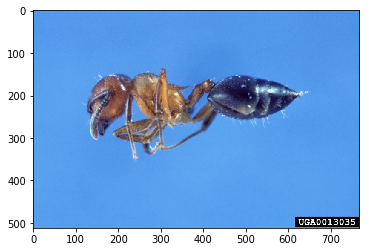

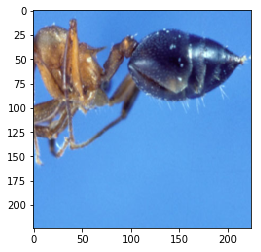

In [3]:
plt.figure()
plt.imshow(image)

t = transforms.RandomResizedCrop(224)
trans_image = t(image)

plt.figure()
plt.imshow(trans_image)

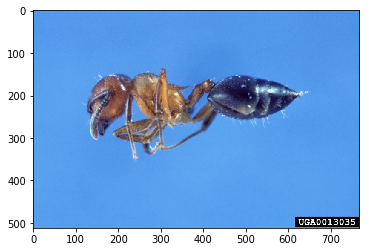

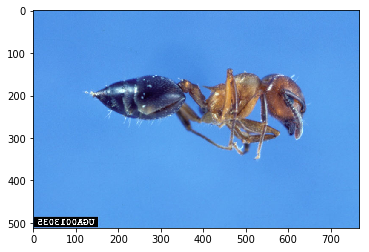

In [4]:
plt.figure()
plt.imshow(image)

t = transforms.RandomHorizontalFlip()
trans_image = t(image)

plt.figure()
plt.imshow(trans_image)

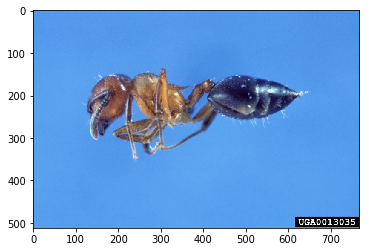

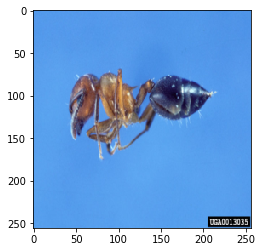

In [5]:
plt.figure()
plt.imshow(image)

t = transforms.Resize((256, 256))
trans_image = t(image)

plt.figure()
plt.imshow(trans_image)

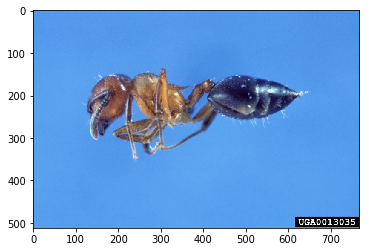

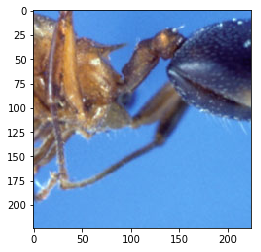

In [6]:
plt.figure()
plt.imshow(image)

t = transforms.CenterCrop(224)
trans_image = t(image)

plt.figure()
plt.imshow(trans_image)

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [8]:
data_dir = os.path.join('data', 'hymenoptera_data')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [9]:
def imshow(images, title=None):
    images = images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    if title is not None:
        plt.title(title)

torch.Size([4, 3, 224, 224]) torch.Size([4])


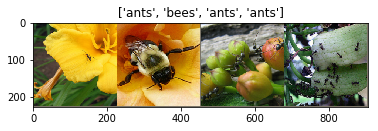

In [10]:
images, classes = next(iter(dataloaders['train']))
print(images.size(), classes.size())
images = torchvision.utils.make_grid(images)
imshow(images, title=[class_names[x] for x in classes])

In [11]:
use_gpu = torch.cuda.is_available()

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # 各エポックで訓練+バリデーションを実行
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)   # training mode
            else:
                model.train(False)  # evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            for data in dataloaders[phase]:
                inputs, labels = data
                
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # サンプル数で割って平均を求める
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            # 精度が改善したらモデルを保存する
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:.4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
model_ft = models.resnet18(pretrained=True)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [13]:
num_features = model_ft.fc.in_features
print(num_features)  # 512

# fc層を置き換える
model_ft.fc = nn.Linear(num_features, 2)
print(model_ft)

512
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

In [14]:
if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# 7エポックごとに学習率を0.1倍する
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
torch.save(model_ft.state_dict(), 'model_ft.pkl')

Epoch 0/24
----------
train Loss: 0.5799 Acc: 0.6885
val Loss: 0.2525 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.4392 Acc: 0.7828
val Loss: 0.2957 Acc: 0.9085

Epoch 2/24
----------
train Loss: 0.4639 Acc: 0.7992
val Loss: 0.3733 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.6490 Acc: 0.7828
val Loss: 0.5341 Acc: 0.7908

Epoch 4/24
----------
train Loss: 0.5548 Acc: 0.7951
val Loss: 0.4096 Acc: 0.8562

Epoch 5/24
----------
train Loss: 0.5385 Acc: 0.8156
val Loss: 0.4832 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.5182 Acc: 0.7705
val Loss: 0.2936 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.3299 Acc: 0.8648
val Loss: 0.2638 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.3675 Acc: 0.8156
val Loss: 0.2295 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.2574 Acc: 0.8811
val Loss: 0.2224 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2438 Acc: 0.9057
val Loss: 0.2082 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.1725 Acc: 0.9344
val Loss: 0.2294 Acc: 0.9216

Ep

In [16]:
# 訓練済みResNet18をロード
model_conv = torchvision.models.resnet18(pretrained=True)

# すべてのパラメータを固定
for param in model_conv.parameters():
    param.requires_grad = False

# 最後のfc層を置き換える
# これはデフォルトの requires_grad=True のままなのでパラメータ更新対象
num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Optimizerの第1引数には更新対象のfc層のパラメータのみ指定
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6197 Acc: 0.6885
val Loss: 0.2443 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.6768 Acc: 0.7049
val Loss: 0.2143 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4952 Acc: 0.7500
val Loss: 0.2717 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.4671 Acc: 0.7910
val Loss: 0.3081 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.4689 Acc: 0.8074
val Loss: 0.2644 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4284 Acc: 0.8156
val Loss: 0.2194 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4592 Acc: 0.7910
val Loss: 0.4082 Acc: 0.8431

Epoch 7/24
----------
train Loss: 0.3523 Acc: 0.8402
val Loss: 0.2191 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3398 Acc: 0.8566
val Loss: 0.2345 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.4039 Acc: 0.7951
val Loss: 0.2317 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.4077 Acc: 0.7910
val Loss: 0.2054 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3182 Acc: 0.8566
val Loss: 0.2241 Acc: 0.9281

Ep

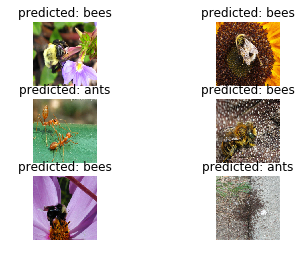

In [18]:
# GPUで学習したモデルのロード
model_ft.load_state_dict(torch.load('model_ft.pkl', map_location=lambda storage, loc: storage))

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    
    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])
            
            if images_so_far == num_images:
                return

visualize_model(model_ft)